In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
#Import visualization libraries 
import matplotlib.pyplot as plt
import seaborn as sns

#Import libraries required for modeling

from sklearn import metrics 
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold
from model_inspector import get_inspector

In [2]:
songs = pd.read_csv('../assets/data/spotify2023_final.csv')

In [3]:
songs.describe()

,artist_count,released_year,released_month,released_day,days_since_launch,days_since_release,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,in_apple_charts,in_deezer_charts,bpm,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
count,952.000000,952.000000,952.000000,952.000000,952.0,952.000000,952.000000,952.000000,9.520000e+02,952.000000,952.000000,952.000000,952.000000,952.000000,952.000000,952.000000,952.000000,952.000000,952.000000,952.000000
mean,1.556723,2018.288866,6.038866,13.944328,5436.0,1792.103992,5202.565126,12.022059,5.141374e+08,67.866597,51.963235,2.669118,122.553571,66.984244,51.406513,64.274160,27.078782,1.582983,18.214286,10.138655
std,0.893331,11.011397,3.564571,9.197223,0.0,4032.503321,7901.400683,19.582405,5.668569e+08,86.470591,50.628850,6.038152,28.069601,14.631282,23.480526,16.558517,26.001599,8.414064,13.718374,9.915399
min,1.000000,1930.000000,1.000000,1.000000,5436.0,43.000000,31.000000,0.000000,2.762000e+03,0.000000,0.000000,0.000000,65.000000,23.000000,4.000000,9.000000,0.000000,0.000000,3.000000,2.000000
25%,1.000000,2020.000000,3.000000,6.000000,5436.0,295.000000,874.500000,0.000000,1.416362e+08,13.000000,7.000000,0.000000,99.750000,57.000000,32.000000,53.000000,6.000000,0.000000,10.000000,4.000000
50%,1.000000,2022.000000,6.000000,13.000000,5436.0,505.000000,2216.500000,3.000000,2.905309e+08,34.000000,38.500000,0.000000,121.000000,69.000000,51.000000,66.000000,18.000000,0.000000,12.000000,6.000000
75%,2.000000,2022.000000,9.000000,22.000000,5436.0,1139.750000,5573.750000,16.000000,6.738690e+08,88.000000,87.000000,2.000000,140.250000,78.000000,70.000000,77.000000,43.000000,0.000000,24.000000,11.000000
max,8.000000,2023.000000,12.000000,31.000000,5436.0,34205.000000,52898.000000,147.000000,3.703895e+09,672.000000,275.000000,58.000000,206.000000,96.000000,97.000000,97.000000,97.000000,91.000000,97.000000,64.000000


In [4]:
songs['streams_per_day'] = np.where(songs.days_since_launch < songs.days_since_release, 
                                    songs.streams/songs.days_since_launch, 
                                    songs.streams/songs.days_since_release)
# songs = songs[songs.days_since_release <= songs.days_since_launch]

In [5]:
# songs['streams_per_day'] = songs.streams/songs.days_since_release
songs.shape

(952, 30)

In [6]:
songs.drop(columns=['released_year',
                    'released_day',
                    'in_spotify_playlists',
                    'in_spotify_charts',
                    'in_apple_playlists',
                    'in_apple_charts',
                    'in_deezer_playlists',
                    'in_deezer_charts',
                    'in_shazam_charts',
                    'date_data_collected',
                    'track_name',
                    'artist(s)_name',
                    'released_date',
                    'days_since_release',
                    'streams',
                    'date_spotify_launched',
                    'days_since_launch',
#                     'instrumentalness_%',
#                     'liveness_%',
                    'key'
                    ], inplace=True)

In [7]:
songs.head()

,artist_count,released_month,bpm,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%,streams_per_day
0,2,7,125,Major,80,89,83,31,0,8,4,3.287947e+06
1,1,3,92,Major,71,61,74,7,0,10,4,8.571557e+05
2,1,6,138,Major,51,32,53,17,0,31,6,2.456210e+06
3,1,8,170,Major,55,58,72,11,0,11,15,5.470224e+05
4,1,5,144,Minor,65,23,80,14,63,11,6,3.032363e+06


In [8]:
songs.isna().sum()

artist_count          0
released_month        0
bpm                   0
mode                  0
danceability_%        0
valence_%             0
energy_%              0
acousticness_%        0
instrumentalness_%    0
liveness_%            0
speechiness_%         0
streams_per_day       0
dtype: int64

In [9]:
songs.dropna(inplace=True)

In [10]:
songs['log_streams_per_day'] = np.log(songs.streams_per_day)
# songs['log_acousticness_%'] = np.log(songs['acousticness_%'])
songs['log_liveness_%'] = np.log(songs['liveness_%'])
songs['log_speechiness_%'] = np.log(songs['speechiness_%'])
# songs['log_instrumentalness_%'] = np.log(songs['instrumentalness_%'])
# songs['log_artist_count'] = np.log(songs.artist_count)
# songs['log2_streams_per_day'] = np.log2(songs.streams_per_day)
# songs['log2_speechiness_%'] = np.log2(songs['speechiness_%'])
# songs['log2_liveness_%'] = np.log2(songs['liveness_%'])

In [11]:
songs = pd.get_dummies(songs, drop_first=True)

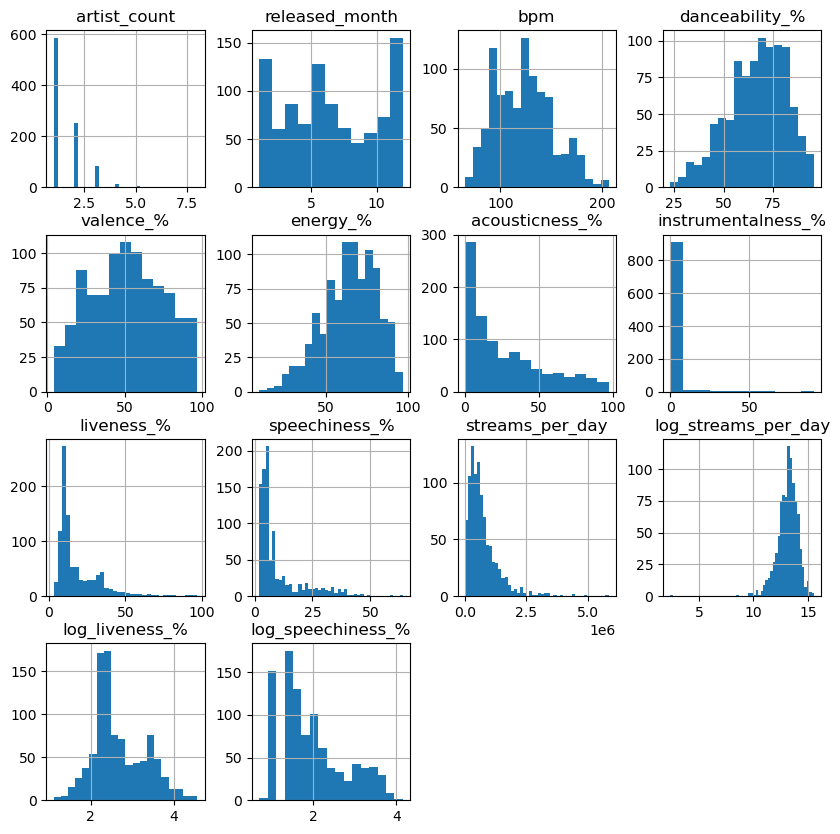

In [12]:
songs.hist(figsize=(10,10), bins='auto');

In [13]:
songs.columns

Index(['artist_count', 'released_month', 'bpm', 'danceability_%', 'valence_%',
       'energy_%', 'acousticness_%', 'instrumentalness_%', 'liveness_%',
       'speechiness_%', 'streams_per_day', 'log_streams_per_day',
       'log_liveness_%', 'log_speechiness_%', 'mode_Minor'],
      dtype='object')

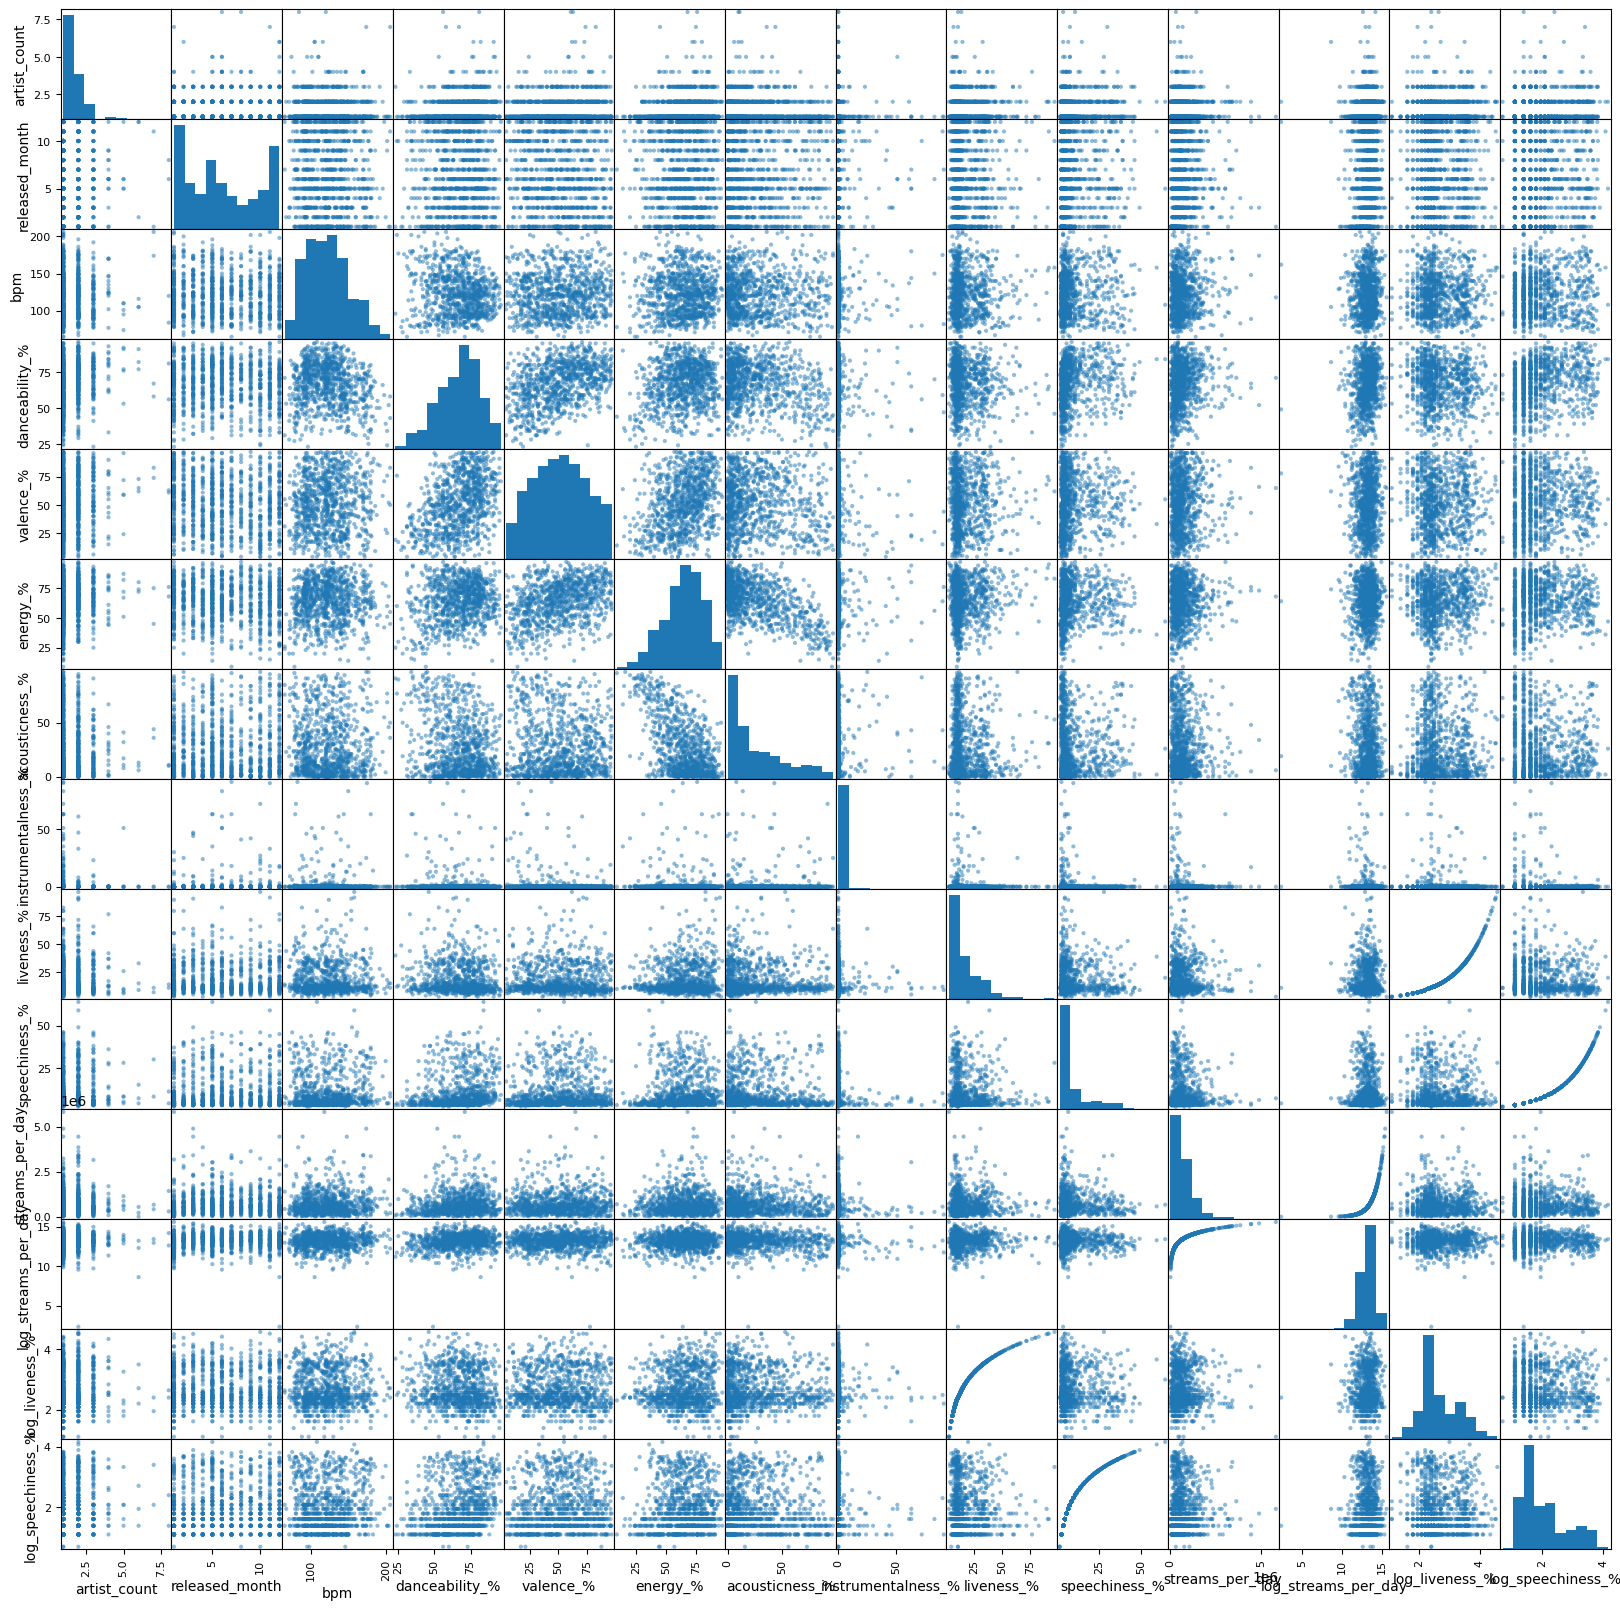

In [14]:
axs = pd.plotting.scatter_matrix(songs.drop(columns=[
#     'key_A#',
#     'key_B',
#     'key_C#',
#     'key_D',
#     'key_D#',
#     'key_E',
#     'key_F',
#     'key_F#',
#     'key_G',
#     'key_G#',
    'mode_Minor']), figsize=(20,20))

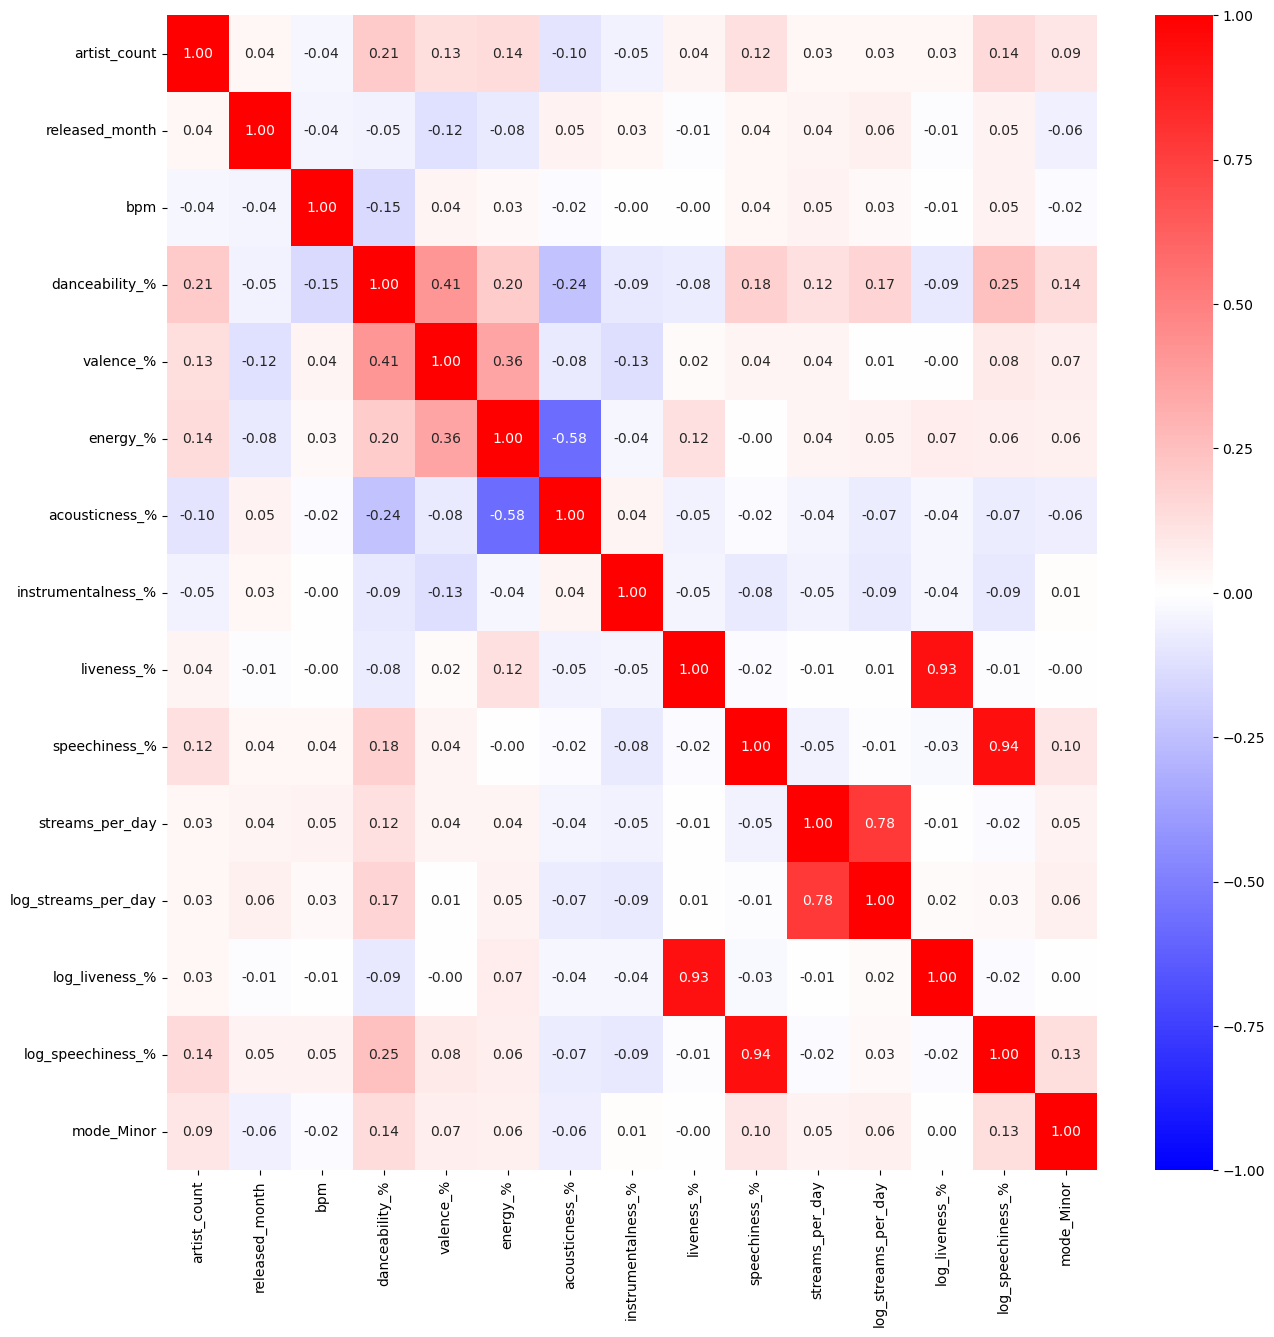

In [15]:
fig, ax = plt.subplots(figsize=(15,15))         
sns.heatmap(
    songs.corr(numeric_only=True), # data
    cmap ='bwr', # colors to use
    center=0, # center of colormap
    vmin=-1, # min val of colormap
    vmax=1, # max value of colormap
    annot=True, # add numbers in add to colors
    fmt='.2f' # use 2 decimal places for numbers
    );

In [16]:
X = songs.drop(columns=['streams_per_day','log_streams_per_day'])
y = songs.log_streams_per_day

X_train, X_test, y_train, y_test = train_test_split(X, y)

lr = LinearRegression()
lr.fit(X_train, y_train)

print(f'Training Data R-Squared: {lr.score(X_train, y_train)}')
print(f'Testing Data R-Squared: {lr.score(X_test, y_test)}')

y_pred = lr.predict(X_test)
print(f'Test Data RMSE: {np.sqrt(metrics.mean_squared_error(y_test, y_pred))}')
print(f'Test Data MAE: {metrics.mean_absolute_error(y_test, y_pred)}')

Training Data R-Squared: 0.06229363974079882
Testing Data R-Squared: 0.012664337446912977
Test Data RMSE: 0.893554890672679
Test Data MAE: 0.7001574008555119


Training Data R-Squared: 0.3300787262051893
Testing Data R-Squared: -0.050792880188168965
Test Data RMSE: 0.9218226712188649
Test Data MAE: 0.7220496922475578


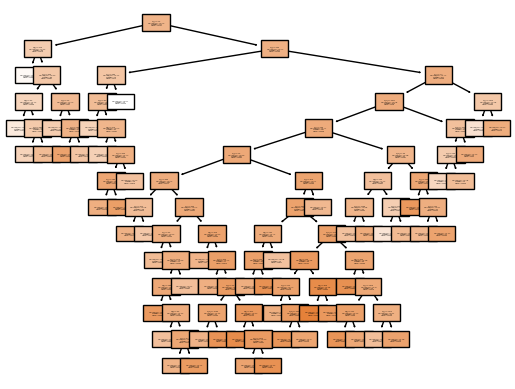

In [17]:
dtr = DecisionTreeRegressor(min_samples_leaf=10)
dtr.fit(X_train, y_train)

print(f'Training Data R-Squared: {dtr.score(X_train, y_train)}')
print(f'Testing Data R-Squared: {dtr.score(X_test, y_test)}')

y_pred = dtr.predict(X_test)
print(f'Test Data RMSE: {np.sqrt(metrics.mean_squared_error(y_test, y_pred))}')
print(f'Test Data MAE: {metrics.mean_absolute_error(y_test, y_pred)}')

plot_tree(dtr, filled=True, fontsize=0);

In [18]:
rfr = RandomForestRegressor(n_estimators=20, n_jobs=-1)
rfr.fit(X_train, y_train)
print(f'Training Data R-Squared: {rfr.score(X_train, y_train)}')
print(f'Testing Data R-Squared: {rfr.score(X_test, y_test)}')

y_pred = rfr.predict(X_test)
print(f'Test Data RMSE: {np.sqrt(metrics.mean_squared_error(y_test, y_pred))}')
print(f'Test Data MAE: {metrics.mean_absolute_error(y_test, y_pred)}')

Training Data R-Squared: 0.8512831720242986
Testing Data R-Squared: -0.03596111197603369
Test Data RMSE: 0.91529386359313
Test Data MAE: 0.7104240192467387


In [36]:
max_feature_vals = [
#     0.5,
    1/3
]
grid = GridSearchCV(
    estimator=RandomForestRegressor(),
    param_grid={'n_estimators': range(10, 400, 25), 
                'max_features':max_feature_vals, 
                'min_samples_leaf':[3]},
    cv=KFold(10, shuffle = True),
    scoring='neg_mean_absolute_error',
    return_train_score=True,
    n_jobs=-1
)
grid.fit(X, y)
#  max_f=1/3, msl=3, n_est=260

GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_features': [0.3333333333333333],
                         'min_samples_leaf': [3],
                         'n_estimators': range(10, 400, 25)},
             return_train_score=True, scoring='neg_mean_absolute_error')

In [37]:
pd.DataFrame(grid.cv_results_)[[
    'mean_train_score',
    'mean_test_score',
    'param_max_features',
    'param_min_samples_leaf', 'param_n_estimators']].sort_values('mean_test_score', ascending=False).head()

,mean_train_score,mean_test_score,param_max_features,param_min_samples_leaf,param_n_estimators
10,-0.397260,-0.653596,0.333333,3,260
1,-0.403295,-0.654022,0.333333,3,35
3,-0.399253,-0.654715,0.333333,3,85
14,-0.396818,-0.654820,0.333333,3,360
15,-0.396995,-0.655607,0.333333,3,385


In [35]:
from sklearn.dummy import DummyRegressor

null_model = DummyRegressor()
null_model.fit(X_train, y_train)
y_pred_null = null_model.predict(X_test)
print(f'R2:{metrics.r2_score(y_test, y_pred_null)}')
print(f'MAE:{metrics.mean_absolute_error(y_test, y_pred_null)}')

R2:-0.0074350577551907104
MAE:0.7011763783061198


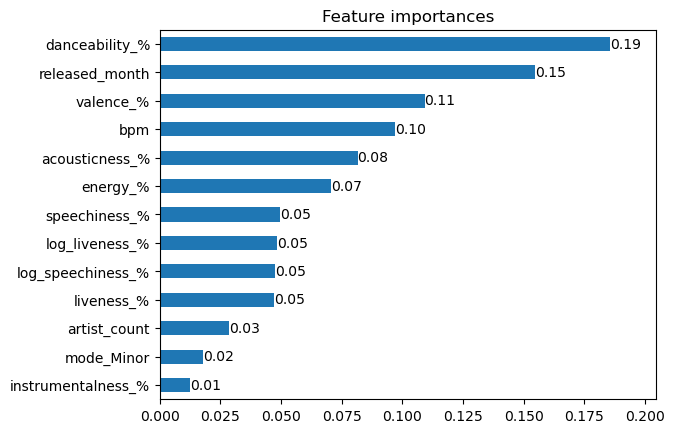

In [22]:
inspector = get_inspector(grid, X, y)
inspector.plot_permutation_importance();

In [23]:
lr_grid = GridSearchCV(
    estimator=LinearRegression(),
    param_grid={},
    cv=KFold(10, shuffle=True),
    scoring='neg_mean_absolute_error',
    return_train_score=True,
    n_jobs=-1
)
lr_grid.fit(X, y)

GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
             estimator=LinearRegression(), n_jobs=-1, param_grid={},
             return_train_score=True, scoring='neg_mean_absolute_error')

In [24]:
pd.DataFrame(lr_grid.cv_results_)[[
    'mean_train_score',
    'mean_test_score',
    ]].sort_values('mean_test_score', ascending=False).head()

,mean_train_score,mean_test_score
0,-0.682816,-0.693881
